In [2]:
import os
import numpy as np
import pandas as pd
from time import sleep, time
from scipy.special import logit
from scipy.stats import beta
from datetime import datetime

In [4]:
# Generate and save inferred model if does not exist
if not os.path.isfile(f"bayesian_model/glmm.pickle"):
    os.system("python3 infer_bayesian_model.py")

## Functions

In [6]:
def run_command_gnome(command, title="test", keep_window=False, test=False):
    if keep_window:
        command_suffix = "; $SHELL"
    else:
        command_suffix = ""
        
    if test:
        return f"""gnome-terminal --title="{title}" --command="bash -c '{command} {command_suffix}'" """
    else:
        os.system(f"""gnome-terminal --title="{title}" --command="bash -c '{command} {command_suffix}'" """)

In [31]:
# Run simulations
def run_simulations():
    setting_files = [os.path.isfile(f"data/{sim_name}/sim_settings_{i}.csv") for i in range(N_PROCESSES)]
    while sum(setting_files)>0:
        setting_files = [os.path.isfile(f"data/{sim_name}/sim_settings_{i}.csv") for i in range(N_PROCESSES)]
        process_active = [os.path.isfile(f"data/{sim_name}/process_{i}_running") for i in range(N_PROCESSES)]

        for i in range(N_PROCESSES):
            if setting_files[i] and not process_active[i]:
                source = "source ~/anaconda3/etc/profile.d/conda.sh\n"
                conda = "conda activate bayes_topic_measures\n"
                c = f"""python3 perform_sig_test.py --trials_per_sim {trials_per_sim} --process {i} --sim_name {sim_name}"""
                run_command_gnome(source+conda+c, title=f"p{i}", keep_window=False) # Laptop
#                 run_command_gnome(c, title=f"p{i}", keep_window=False) # Desktop

        sleep(10)

## Specificity Simulations

In [26]:
# Settings for hoyle's significance testing
hoyle_total_scores = 50*26*2 #2 models * 50 topics per model * 26 scores per topic
hoyle_p_diff = 0.055
hoyle_scores_per_r = 38
hoyle_n_raters = hoyle_total_scores//hoyle_scores_per_r

In [33]:
# Varying the number of raters
N_PROCESSES = 4
sim_name = "5_specificity"
n_sims = 30
trials_per_sim = 1

p_diff = 0
n_raters = hoyle_n_raters
scores_per_r = hoyle_scores_per_r

# Removing all produced files
os.system(f"""rm data/{sim_name}/*""")

# Generate settings file
os.system(f"""
    python3 generate_sim_settings.py --n_raters "{n_raters}" --scores_per_r {scores_per_r} \
    --n_sims {n_sims} --trials_per_sim {trials_per_sim} --sim_name {sim_name} --p_diff {p_diff}
""")

run_simulations()


    p_diff=0.0, <class 'float'>
    n_raters=68, <class 'int'>
    scores_per_r=38, <class 'int'>
    total_scores=None, <class 'NoneType'>
    n_sims=30, <class 'int'>
    trials_per_sim=1
    seed=42, <class 'int'>
    sim_name=5_specificity, <class 'str'>
    chain_method=vectorized, <class 'str'>
    clean_dir=True, <class 'bool'>
    


# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.


In [23]:
df = pd.read_csv(f"data/simulations/spec.csv")

[]

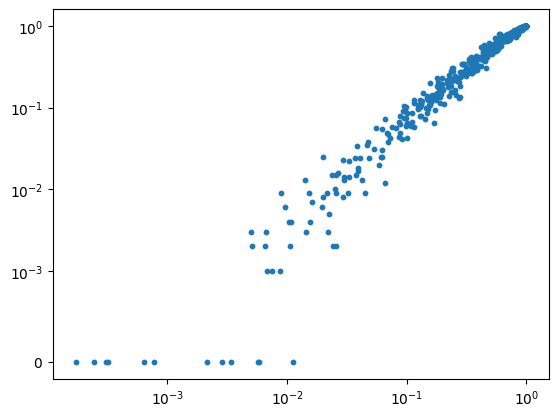

In [15]:
from matplotlib import pyplot as plt

plt.scatter(x=df["propz_pval"][:500], y=df["bht_pval"][:500], s=10)
plt.yscale("symlog", linthresh=1e-3)
plt.xscale("symlog", linthresh=1e-3)

plt.plot()

In [24]:
from scipy.stats import uniform, norm, bernoulli, pearsonr
def jitter(arr, scale="linear"):
    if scale=="log":
        return arr+uniform.rvs(-1e-4,1e-4,len(arr))
    elif scale=="linear":
        return arr+uniform.rvs(-1/2,1,len(arr))

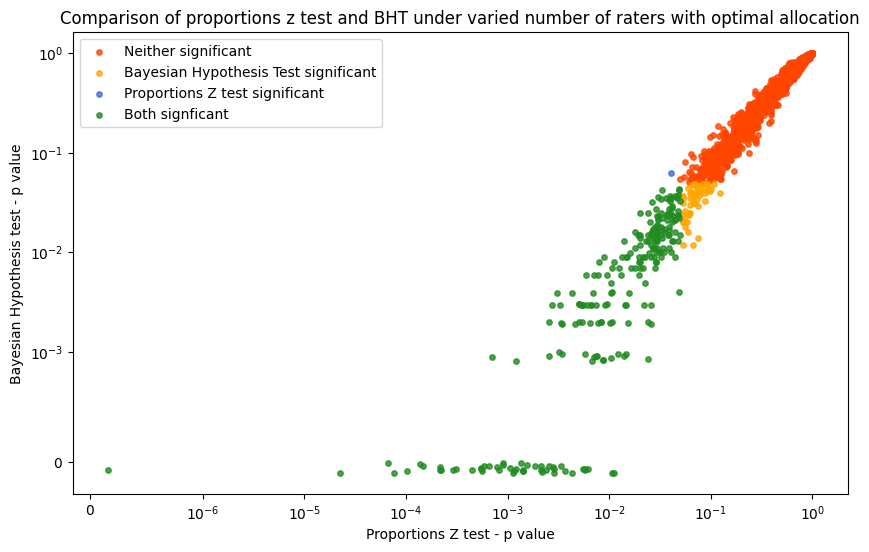

In [25]:
# Comparing prop z test and bh test under different number of raters
sim_results=df

legend = {
    "orangered":"Neither significant",
    "orange":"Bayesian Hypothesis Test significant",
    "royalblue": "Proportions Z test significant",
    "forestgreen": "Both signficant"
}

alpha = 0.05
sim_results["propz"] = sim_results["propz_pval"] < alpha
sim_results["bht"] = sim_results["bht_pval"] < alpha

sim_results["c"] = np.select(
    condlist=[
        ~sim_results["propz"] & ~sim_results["bht"],
        ~sim_results["propz"] & sim_results["bht"],
        sim_results["propz"] & ~sim_results["bht"],
        sim_results["propz"] & sim_results["bht"]
    ],
    choicelist=["orangered", "orange", "royalblue", "forestgreen"],
    default="black")

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for colour in legend:
    df = sim_results[sim_results["c"]==colour]
    ax.scatter(df["propz_pval"], jitter(df["bht_pval"],scale="log"), c=colour, 
               label=legend[colour], s=15, alpha=0.8)
ax.set_title("Comparison of proportions z test and BHT under varied number of raters with optimal allocation")
ax.set_yscale("symlog", linthresh=1e-3)
ax.set_xscale("symlog", linthresh=1e-6)
ax.set_xlabel("Proportions Z test - p value")
ax.set_ylabel("Bayesian Hypothesis test - p value")
ax.legend()
plt.show()

,sim_id,trial_id,p_diff,n_raters,scores_per_r,total_scores,propz_pval,bht_pval,seed,propz,bht,c
